In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import keras
import pickle
import os
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras import regularizers

Using TensorFlow backend.


In [2]:
from models import *

In [3]:
from gen_train_test_data import *
from simtools import *
%load_ext autoreload
%autoreload 2

# load scaler        
with open("model/scaler_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        scaler=pickle.load(f)

In [4]:
date_pool=pd.date_range("1/1/2019","1/31/2019",freq="B").strftime("%Y%m%d")
date_pool=[d for d in date_pool if os.path.exists(data_dir+"trades_{}_{}.csv".format(d,ticker))]

train_days=10
train_date_list=date_pool[:train_days]
test_date_list=date_pool[train_days+1:]

In [5]:
## Global Constants

In [6]:
ticker="TSLA"

time_steps = 50

## Load Models

In [7]:
import os
import re

model_list = os.listdir("model/")
model_list = [s for s in model_list if ((re.search(r'scaler', s) is None) and (re.search(r'[a-zA-Z0-9]*\.p', s)))]

print(model_list)

['Random_Forest_20190102_20190115.p', 'GradientBoost_20190102_20190115.p', 'RandomForest_20190102_20190115.p', 'XGBoost_20190102_20190115.p', 'LSTM_20190102_20190115.p', 'CNN_20190102_20190115.p']


## Model Prediction

In [8]:
import vwap2 as vw
matplotlib.rcParams[ 'figure.figsize' ] = ( 16, 9 )
vwap_coefs = [ 9.95503275e-03, -1.01533564e-04,  5.73879785e-07, -1.47027197e-09, 1.38993793e-12]
#test_date_list_new=list(test_taq.keys())
#day = test_taq[test_date_list_new[0]]
#day[~day.trade_px.isna()]

In [9]:
def test_vwap(day, order_quantity, order_side, schedule_coef = 0.0, tick_coef = 0., model_coef = 1.,model=True):
    results = vw.algo_loop(day, order_side, order_quantity, vwap_coefs, schedule_coef = schedule_coef,\
                           tick_coef = tick_coef, model_coef = model_coef, using_model=model)
    display_result(results,False)
    return results

def display_result(results,plot=True):
    data = results['trades']
    if plot:
        print("FV and midpoints:")
        plt.plot(results['fair_values'].index,results['fair_values'].values,color='r')
        plt.plot(results['midpoints'].index,results['midpoints'].values,color='r')
        plt.legend(["fair_values","midpoints"])
        plt.show()
        print("Trade prices:")
        plt.plot(data.price.index,data.price.values,color=taolaoshi[0])
        plt.show()
    print("percentage of aggressive order:",np.mean(data['trade_type']=="a"))
    print("last_min_order:",results['last_min_order'])
    print("avg price:",results['avg_price'])
    print("day_vwap price:",results['day_vwap'])
    print("avg - day_vwap:",results['avg_price'] - results['day_vwap'])

In [19]:
def model_vwap_evaluation(model):
    for date in test_date_list:
        if not os.path.exists("test_result/x_test_{}.p".format(date)):
            x,idx=create_test_dataset(ticker=ticker,time_steps = time_steps, input_scaler=scaler, date=date)
            print(x.shape,idx.shape)
            with open("test_result/x_test_{}.p".format(date),"wb") as f:
                    pickle.dump(x,f)
        
        x = None
        with open("test_result/x_test_{}.p".format(date),"rb") as f:
            x = pickle.load(f)

        # Using Model for Prediction
        signal=model.predict(x)
        with open("test_result/signal_test_{}.p".format(date),"wb") as f:
                pickle.dump(signal,f)
        
        log_message( "{} finished".format(date) )

    test_taq=dict()

    for date in test_date_list:
        if os.path.exists("test_result/x_test_{}.p".format(date)) and os.path.exists(data_dir+"quotes_{}_TSLA.csv".format(date)):

            with open("test_result/signal_test_{}.p".format(date),"rb") as f:
                signal=pickle.load(f)
            #print(signal[-100:])

            # generate signal and attach it to original df
            if len(signal.shape) > 1:
                signal_discrete=signal.argmax(axis=1)-1
            else:
                signal_discrete=signal
            #signal_continuous=np.dot(signal,np.array([[-1],[0],[1]])).ravel()

            trades = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(date, ticker),index_col=[0],parse_dates=[0])
            N=len(trades)

            signal_discrete=np.concatenate((np.zeros(N-len(signal_discrete))+np.nan,signal_discrete), axis=0)
            trades[["signal_discrete"]]=pd.DataFrame({"signal_discrete":signal_discrete,},index=trades.index)

            # merge TAQ
            quotes=pd.read_csv(data_dir+"quotes_{}_TSLA.csv".format(date),index_col=[0],parse_dates=[0])
            taq=makeTAQfile(trades, quotes)
            test_taq[date]=taq

            log_message( "{} finished".format(date) )
    i=0

    vwap_list=[]
    #avg_list_tick=[]
    avg_list_model_s=[]
    avg_list_model_b=[]
    avg_spread=[]

    model_coef=0.1

    for date in test_taq.keys():
        print("-------------------------------------------------------------------------------------------------")
        day=test_taq[date]
        #print("----------------Tick-----------------")
        #r_tick=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -1.0, tick_coef = 1., LSTM_coef = 0.,LSTM=False)
        print("----------------{}-----------------".format(model.model_name))
        
        # Model Coef:
        # buy: if the next step is 1, predicted price increase, then fair value should increase, inclined to buy now, so model_coef = 1
        # sell: if the next step is 1, predicted price increase, then fair value should increase, inclined to wai now, so model_coef = 1
        
        # Schedule Coef:
        # buy: if fall behind, factor positive, then to encourage buy, then fair value should increase, inclined to buy now, so model_coef = 1
        # sell: if fall behind, factor positive, then to encourage sell, then fair value should decrease, inclined to buy now, so model_coef = -1
        r_model_b=test_vwap(day, order_quantity=300000, order_side="b", schedule_coef = 2., tick_coef = 0., model_coef = 0.5, model=True)
        r_model_s=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -2., tick_coef = 0., model_coef = 0.5, model=True)
        

        vwap_list.append(r_model_s['day_vwap'])
        #avg_list_tick.append(r_tick['avg_price'])
        avg_list_model_b.append(r_model_b['avg_price'])
        avg_list_model_s.append(r_model_s['avg_price'])
        avg_spread.append(r_model_s["avg_spread"])

        log_message( "{} finished".format(date) )
    
    return (vwap_list, avg_list_model_b, avg_list_model_s, test_taq)

# Running of each model

## CNN

In [20]:
with open("model/CNN_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
        print(model.model_name)

CNN


In [21]:
vwap_list, avg_list_CNN_b, avg_list_CNN_s, test_taq = model_vwap_evaluation(model)

2020-04-24 00:52:54:154703: 20190117 finished
2020-04-24 00:53:24:045967: 20190118 finished
2020-04-24 00:53:39:090913: 20190122 finished
2020-04-24 00:53:56:631677: 20190123 finished
2020-04-24 00:54:07:914833: 20190124 finished
2020-04-24 00:54:18:163640: 20190125 finished
2020-04-24 00:54:27:268222: 20190128 finished
2020-04-24 00:54:33:882353: 20190129 finished
2020-04-24 00:54:47:668678: 20190130 finished
2020-04-24 00:55:03:383362: 20190131 finished
2020-04-24 00:55:03:531323: start merge
2020-04-24 00:55:03:559123: end merge
2020-04-24 00:55:03:559241: 20190117 finished
2020-04-24 00:55:04:081850: start merge
2020-04-24 00:55:04:243144: end merge
2020-04-24 00:55:04:243365: 20190118 finished
2020-04-24 00:55:04:443346: start merge
2020-04-24 00:55:04:494880: end merge
2020-04-24 00:55:04:495015: 20190124 finished
2020-04-24 00:55:04:658836: start merge
2020-04-24 00:55:04:700069: end merge
2020-04-24 00:55:04:700170: 20190125 finished
2020-04-24 00:55:04:832137: start merge
2020

2020-04-24 01:05:26:360701: end simulation loop
2020-04-24 01:05:26:360789: order analytics
2020-04-24 01:05:26:363169: VWAP run complete.
percentage of aggressive order: 0.42776203966005666
last_min_order: 30555.0
avg price: 303.0957386
day_vwap price: 303.60644835608593
avg - day_vwap: -0.5107097560859302
2020-04-24 01:05:26:381973: 20190130 finished
-------------------------------------------------------------------------------------------------
----------------CNN-----------------
2020-04-24 01:05:26:382060: Beginning VWAP run: b 300000 shares
2020-04-24 01:05:26:400158: starting main loop
2020-04-24 01:06:17:950552: end simulation loop
2020-04-24 01:06:17:950644: order analytics
2020-04-24 01:06:17:952968: VWAP run complete.
percentage of aggressive order: 0.4256480218281037
last_min_order: 22573.0
avg price: 305.23743899999994
day_vwap price: 304.9707644846737
avg - day_vwap: 0.2666745153262582
2020-04-24 01:06:17:969385: Beginning VWAP run: s 300000 shares
2020-04-24 01:06:17:98

## LSTM

In [22]:
with open("model/LSTM_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
        print(model.model_name)
vwap_list, avg_list_LSTM_b, avg_list_LSTM_s, _ = model_vwap_evaluation(model)

LSTM
2020-04-24 01:08:04:081277: 20190117 finished
2020-04-24 01:13:52:667774: 20190118 finished
2020-04-24 01:16:41:444981: 20190122 finished
2020-04-24 01:19:54:691857: 20190123 finished
2020-04-24 01:21:50:474338: 20190124 finished
2020-04-24 01:23:36:132280: 20190125 finished
2020-04-24 01:25:10:253814: 20190128 finished
2020-04-24 01:26:19:152194: 20190129 finished
2020-04-24 01:28:42:006117: 20190130 finished
2020-04-24 01:31:38:420074: 20190131 finished
2020-04-24 01:31:38:582855: start merge
2020-04-24 01:31:38:612652: end merge
2020-04-24 01:31:38:612751: 20190117 finished
2020-04-24 01:31:39:134535: start merge
2020-04-24 01:31:39:292985: end merge
2020-04-24 01:31:39:293100: 20190118 finished
2020-04-24 01:31:39:454207: start merge
2020-04-24 01:31:39:505465: end merge
2020-04-24 01:31:39:505621: 20190124 finished
2020-04-24 01:31:39:649905: start merge
2020-04-24 01:31:39:692991: end merge
2020-04-24 01:31:39:693110: 20190125 finished
2020-04-24 01:31:39:842287: start merge

2020-04-24 01:41:59:048196: end simulation loop
2020-04-24 01:41:59:048284: order analytics
2020-04-24 01:41:59:050649: VWAP run complete.
percentage of aggressive order: 0.42141863699582754
last_min_order: 28849.0
avg price: 303.0597770333333
day_vwap price: 303.60644835608593
avg - day_vwap: -0.5466713227526157
2020-04-24 01:41:59:070508: 20190130 finished
-------------------------------------------------------------------------------------------------
----------------LSTM-----------------
2020-04-24 01:41:59:070576: Beginning VWAP run: b 300000 shares
2020-04-24 01:41:59:090601: starting main loop
2020-04-24 01:42:50:358046: end simulation loop
2020-04-24 01:42:50:358156: order analytics
2020-04-24 01:42:50:360869: VWAP run complete.
percentage of aggressive order: 0.4279835390946502
last_min_order: 22094.0
avg price: 305.2391196
day_vwap price: 304.9707644846737
avg - day_vwap: 0.2683551153263011
2020-04-24 01:42:50:378661: Beginning VWAP run: s 300000 shares
2020-04-24 01:42:50:38

## Random Forest

In [23]:
with open("model/Random_Forest_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
vwap_list, avg_list_RF_b, avg_list_RF_s, _ = model_vwap_evaluation(model)

2020-04-24 01:43:42:865982: 20190117 finished
2020-04-24 01:43:51:390926: 20190118 finished
2020-04-24 01:43:54:856636: 20190122 finished
2020-04-24 01:43:58:617457: 20190123 finished
2020-04-24 01:44:00:794279: 20190124 finished
2020-04-24 01:44:02:674321: 20190125 finished
2020-04-24 01:44:04:441428: 20190128 finished
2020-04-24 01:44:05:537982: 20190129 finished
2020-04-24 01:44:08:901506: 20190130 finished
2020-04-24 01:44:13:007578: 20190131 finished
2020-04-24 01:44:13:089562: start merge
2020-04-24 01:44:13:109535: end merge
2020-04-24 01:44:13:109619: 20190117 finished
2020-04-24 01:44:13:562593: start merge
2020-04-24 01:44:13:722776: end merge
2020-04-24 01:44:13:722903: 20190118 finished
2020-04-24 01:44:13:902462: start merge
2020-04-24 01:44:13:952743: end merge
2020-04-24 01:44:13:952862: 20190124 finished
2020-04-24 01:44:14:116351: start merge
2020-04-24 01:44:14:159305: end merge
2020-04-24 01:44:14:159411: 20190125 finished
2020-04-24 01:44:14:297545: start merge
2020

2020-04-24 01:54:31:149396: end simulation loop
2020-04-24 01:54:31:149492: order analytics
2020-04-24 01:54:31:151873: VWAP run complete.
percentage of aggressive order: 0.4425287356321839
last_min_order: 26440.0
avg price: 302.99823403333335
day_vwap price: 303.60644835608593
avg - day_vwap: -0.6082143227525876
2020-04-24 01:54:31:171118: 20190130 finished
-------------------------------------------------------------------------------------------------
----------------Random_Forest-----------------
2020-04-24 01:54:31:171215: Beginning VWAP run: b 300000 shares
2020-04-24 01:54:31:190463: starting main loop
2020-04-24 01:55:21:941618: end simulation loop
2020-04-24 01:55:21:941707: order analytics
2020-04-24 01:55:21:943930: VWAP run complete.
percentage of aggressive order: 0.4388888888888889
last_min_order: 22410.0
avg price: 305.2378904666667
day_vwap price: 304.9707644846737
avg - day_vwap: 0.26712598199304693
2020-04-24 01:55:21:960890: Beginning VWAP run: s 300000 shares
2020-0

## Gradient Boost

In [25]:
with open("model/GradientBoost_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
vwap_list, avg_list_GB_b, avg_list_GB_s, _ = model_vwap_evaluation(model)

2020-04-24 10:01:16:546806: 20190117 finished
2020-04-24 10:01:30:119512: 20190118 finished
2020-04-24 10:01:35:479856: 20190122 finished
2020-04-24 10:01:40:833668: 20190123 finished
2020-04-24 10:01:43:848600: 20190124 finished
2020-04-24 10:01:47:112970: 20190125 finished
2020-04-24 10:01:50:697400: 20190128 finished
2020-04-24 10:01:53:118625: 20190129 finished
2020-04-24 10:01:58:606673: 20190130 finished
2020-04-24 10:02:05:635259: 20190131 finished
2020-04-24 10:02:05:737385: start merge
2020-04-24 10:02:05:759920: end merge
2020-04-24 10:02:05:760008: 20190117 finished
2020-04-24 10:02:06:233866: start merge
2020-04-24 10:02:06:372583: end merge
2020-04-24 10:02:06:372721: 20190118 finished
2020-04-24 10:02:06:524266: start merge
2020-04-24 10:02:06:565631: end merge
2020-04-24 10:02:06:565745: 20190124 finished
2020-04-24 10:02:06:714475: start merge
2020-04-24 10:02:06:758095: end merge
2020-04-24 10:02:06:758218: 20190125 finished
2020-04-24 10:02:06:893945: start merge
2020

2020-04-24 10:13:31:497055: end simulation loop
2020-04-24 10:13:31:497165: order analytics
2020-04-24 10:13:31:500310: VWAP run complete.
percentage of aggressive order: 0.1133768352365416
last_min_order: 81383.0
avg price: 304.0661343666667
day_vwap price: 303.60644835608593
avg - day_vwap: 0.45968601058075365
2020-04-24 10:13:31:519021: 20190130 finished
-------------------------------------------------------------------------------------------------
----------------GradientBoost-----------------
2020-04-24 10:13:31:519088: Beginning VWAP run: b 300000 shares
2020-04-24 10:13:31:538475: starting main loop
2020-04-24 10:14:23:763105: end simulation loop
2020-04-24 10:14:23:763195: order analytics
2020-04-24 10:14:23:765505: VWAP run complete.
percentage of aggressive order: 0.6777777777777778
last_min_order: 10628.0
avg price: 305.262751
day_vwap price: 304.9707644846737
avg - day_vwap: 0.2919865153263004
2020-04-24 10:14:23:780766: Beginning VWAP run: s 300000 shares
2020-04-24 10:1

## XGBoost

In [26]:
with open("model/XGBoost_{}_{}.p".format(train_date_list[0],train_date_list[-1]),"rb") as f:
        model=pickle.load(f)
vwap_list, avg_list_XGB_b, avg_list_XGB_s, _ = model_vwap_evaluation(model)

2020-04-24 10:15:30:793841: 20190117 finished
2020-04-24 10:15:38:211385: 20190118 finished
2020-04-24 10:15:41:354517: 20190122 finished
2020-04-24 10:15:44:442473: 20190123 finished
2020-04-24 10:15:46:589327: 20190124 finished
2020-04-24 10:15:48:506849: 20190125 finished
2020-04-24 10:15:50:129429: 20190128 finished
2020-04-24 10:15:51:404822: 20190129 finished
2020-04-24 10:15:54:685102: 20190130 finished
2020-04-24 10:15:58:115209: 20190131 finished
2020-04-24 10:15:58:262022: start merge
2020-04-24 10:15:58:287713: end merge
2020-04-24 10:15:58:287824: 20190117 finished
2020-04-24 10:15:58:872737: start merge
2020-04-24 10:15:59:050659: end merge
2020-04-24 10:15:59:050800: 20190118 finished
2020-04-24 10:15:59:240916: start merge
2020-04-24 10:15:59:292211: end merge
2020-04-24 10:15:59:292353: 20190124 finished
2020-04-24 10:15:59:466508: start merge
2020-04-24 10:15:59:519374: end merge
2020-04-24 10:15:59:519498: 20190125 finished
2020-04-24 10:15:59:676323: start merge
2020

2020-04-24 10:27:49:944875: end simulation loop
2020-04-24 10:27:49:944971: order analytics
2020-04-24 10:27:49:947473: VWAP run complete.
percentage of aggressive order: 0.11012861736334405
last_min_order: 82629.0
avg price: 304.0894543
day_vwap price: 303.60644835608593
avg - day_vwap: 0.4830059439140655
2020-04-24 10:27:49:965870: 20190130 finished
-------------------------------------------------------------------------------------------------
----------------XGBoost-----------------
2020-04-24 10:27:49:965935: Beginning VWAP run: b 300000 shares
2020-04-24 10:27:49:987417: starting main loop
2020-04-24 10:28:46:555385: end simulation loop
2020-04-24 10:28:46:555481: order analytics
2020-04-24 10:28:46:557574: VWAP run complete.
percentage of aggressive order: 0.673992673992674
last_min_order: 9986.0
avg price: 305.2623442333333
day_vwap price: 304.9707644846737
avg - day_vwap: 0.2915797486596148
2020-04-24 10:28:46:574247: Beginning VWAP run: s 300000 shares
2020-04-24 10:28:46:58

## Tick Factor

In [27]:
test_taq=dict()

for date in test_date_list:
    if os.path.exists("test_result/x_test_{}.p".format(date)) and os.path.exists(data_dir+"quotes_{}_TSLA.csv".format(date)):
        
        trades = pd.read_csv(data_dir+'trades_{}_{}.csv'.format(date, ticker),index_col=[0],parse_dates=[0])
        
        
        # merge TAQ
        quotes=pd.read_csv(data_dir+"quotes_{}_TSLA.csv".format(date),index_col=[0],parse_dates=[0])
        taq=makeTAQfile(trades, quotes)
        print(taq.shape)
        test_taq[date]=taq
        
        log_message( "{} finished".format(date) )

2020-04-24 10:29:46:603668: start merge
2020-04-24 10:29:46:631383: end merge
(50301, 9)
2020-04-24 10:29:46:631531: 20190117 finished
2020-04-24 10:29:47:196094: start merge
2020-04-24 10:29:47:368048: end merge
(428445, 9)
2020-04-24 10:29:47:368264: 20190118 finished
2020-04-24 10:29:47:563904: start merge
2020-04-24 10:29:47:609001: end merge
(113260, 9)
2020-04-24 10:29:47:609122: 20190124 finished
2020-04-24 10:29:47:769845: start merge
2020-04-24 10:29:47:812798: end merge
(99211, 9)
2020-04-24 10:29:47:812935: 20190125 finished
2020-04-24 10:29:47:960160: start merge
2020-04-24 10:29:48:002416: end merge
(89710, 9)
2020-04-24 10:29:48:002570: 20190128 finished
2020-04-24 10:29:48:126592: start merge
2020-04-24 10:29:48:156580: end merge
(66041, 9)
2020-04-24 10:29:48:156737: 20190129 finished
2020-04-24 10:29:48:449124: start merge
2020-04-24 10:29:48:519410: end merge
(202140, 9)
2020-04-24 10:29:48:519530: 20190130 finished
2020-04-24 10:29:48:760316: start merge
2020-04-24 1

In [28]:
avg_list_tick_b, avg_list_tick_s=[], []

model_coef=0.1

for date in test_taq.keys():
    print("-------------------------------------------------------------------------------------------------")
    day=test_taq[date]
    print("----------------Tick-----------------")
    # Tick Coef:
    # buy: if tick is 1, increase momentum, then fair value should increase, inclined to buy now, so model_coef = 1
    # sell: if tick is 1, increase momentum,  then fair value should increase, inclined to wait, so model_coef = 1
    r_tick_b=test_vwap(day, order_quantity=300000, order_side="b", schedule_coef = 2., tick_coef = 0.5, model_coef = 0.,model=False)
    r_tick_s=test_vwap(day, order_quantity=300000, order_side="s", schedule_coef = -2., tick_coef = 0.5, model_coef = 0.,model=False)
    
    avg_list_tick_b.append(r_tick_b['avg_price'])
    avg_list_tick_s.append(r_tick_s['avg_price'])

    log_message( "{} finished".format(date) )

-------------------------------------------------------------------------------------------------
----------------Tick-----------------
2020-04-24 10:29:48:874489: Beginning VWAP run: b 300000 shares
2020-04-24 10:29:48:885159: starting main loop
2020-04-24 10:30:06:519051: end simulation loop
2020-04-24 10:30:06:519155: order analytics
2020-04-24 10:30:06:521500: VWAP run complete.
percentage of aggressive order: 0.24720357941834453
last_min_order: 34545.0
avg price: 347.39161953333337
day_vwap price: 347.7609699903627
avg - day_vwap: -0.3693504570293271
2020-04-24 10:30:06:525509: Beginning VWAP run: s 300000 shares
2020-04-24 10:30:06:532234: starting main loop
2020-04-24 10:30:24:395633: end simulation loop
2020-04-24 10:30:24:395729: order analytics
2020-04-24 10:30:24:397989: VWAP run complete.
percentage of aggressive order: 0.21003134796238246
last_min_order: 37569.0
avg price: 347.2544254333333
day_vwap price: 347.7609699903627
avg - day_vwap: -0.5065445570293718
2020-04-24 10

# Comparison of Models

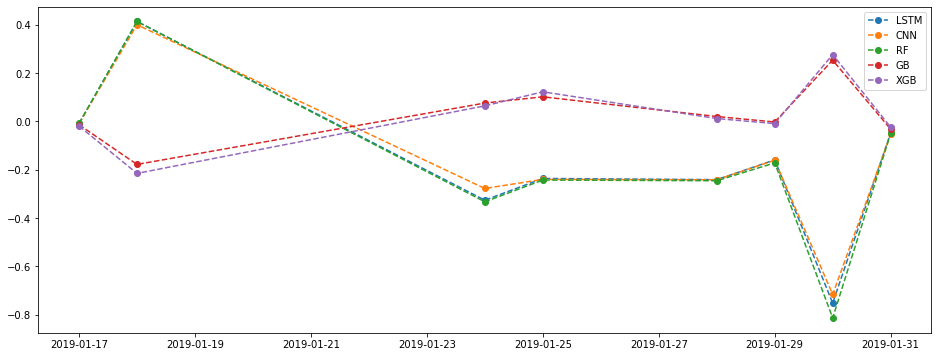

In [29]:
df_compare=pd.DataFrame({"Tick factor":avg_list_tick_s,
                         "LSTM factor":avg_list_LSTM_s,
                         "CNN factor":avg_list_CNN_s,
                         "RandomForest factor":avg_list_RF_s,
                         "GradientBoost factor":avg_list_GB_s,
                         "XGBoost factor":avg_list_XGB_s,
                        },
                        index=pd.to_datetime(list(test_taq.keys())))
df_compare["Avg LSTM - Avg factor"]=df_compare["LSTM factor"]-df_compare["Tick factor"]
df_compare["Avg CNN - Avg factor"]=df_compare["CNN factor"]-df_compare["Tick factor"]
df_compare["Avg RandomForest - Avg factor"]=df_compare["RandomForest factor"]-df_compare["Tick factor"]
df_compare["Avg GradientBoost - Avg factor"]=df_compare["GradientBoost factor"]-df_compare["Tick factor"]
df_compare["Avg XGBoost - Avg factor"]=df_compare["XGBoost factor"]-df_compare["Tick factor"]
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df_compare.index,df_compare["Avg LSTM - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg CNN - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg RandomForest - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg GradientBoost - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg XGBoost - Avg factor"].values,'o--')
plt.legend(["LSTM", "CNN", "RF", "GB", "XGB"])

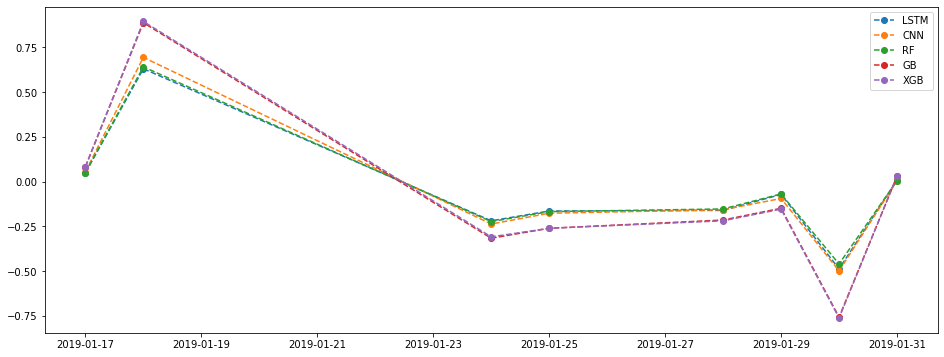

In [30]:
df_compare=pd.DataFrame({"Tick factor":avg_list_tick_b,
                         "LSTM factor":avg_list_LSTM_b,
                         "CNN factor":avg_list_CNN_b,
                         "RandomForest factor":avg_list_RF_b,
                         "GradientBoost factor":avg_list_GB_b,
                         "XGBoost factor":avg_list_XGB_b,
                        },
                        index=pd.to_datetime(list(test_taq.keys())))
df_compare["Avg LSTM - Avg factor"]=df_compare["LSTM factor"]-df_compare["Tick factor"]
df_compare["Avg CNN - Avg factor"]=df_compare["CNN factor"]-df_compare["Tick factor"]
df_compare["Avg RandomForest - Avg factor"]=df_compare["RandomForest factor"]-df_compare["Tick factor"]
df_compare["Avg GradientBoost - Avg factor"]=df_compare["GradientBoost factor"]-df_compare["Tick factor"]
df_compare["Avg XGBoost - Avg factor"]=df_compare["XGBoost factor"]-df_compare["Tick factor"]
fig,ax=plt.subplots(figsize=(16,6))
ax.plot(df_compare.index,df_compare["Avg LSTM - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg CNN - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg RandomForest - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg GradientBoost - Avg factor"].values,'o--')
ax.plot(df_compare.index,df_compare["Avg XGBoost - Avg factor"].values,'o--')
plt.legend(["LSTM", "CNN", "RF", "GB", "XGB"])